# Download the dataset and supporting codes and pre-trained models

https://drive.google.com/file/d/1D3m6I2S8xIvdOHBkvwSSFof5OTJZCDSt/view?usp=drivesdk

https://drive.google.com/file/d/1CDRMyBA3Hk_gmbk1xkAm7aRHXBOQQigu/view?usp=drivesdk

https://drive.google.com/file/d/1so6AQ0_Pg255COjAzEOOVPlDzTJFVQro/view?usp=drivesdk

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload
def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())
id_to_fn = {
# '1D3rH-gSxIECZnoyc5k77PEucKBVzoiBc': 'edges2shoes.zip',
'1D3m6I2S8xIvdOHBkvwSSFof5OTJZCDSt': 'edges2shoes.zip',
'1CDRMyBA3Hk_gmbk1xkAm7aRHXBOQQigu': 'CycleGAN_support.zip',
# '1so6AQ0_Pg255COjAzEOOVPlDzTJFVQro': 'test_case.zip',
'1l7gHikhCz64hYHL4n_Ps7nufQcddcRyR': 'test_case.zip'

}
# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

In [3]:
! unzip -q edges2shoes.zip
! unzip -q CycleGAN_support.zip
! unzip -q test_case.zip

# CycleGAN training

In [ ]:
import torch
import pdb

D_A = torch.load('test_case/D_A.pt')
D_B = torch.load('test_case/D_B.pt')
G_BA = torch.load('test_case/G_BA.pt')
G_AB = torch.load('test_case/G_AB.pt')
valid = torch.load('test_case/valid.pt')
fake = torch.load('test_case/fake.pt')
fake_A = torch.load('test_case/fake_A.pt')
fake_B = torch.load('test_case/fake_B.pt')
real_A = torch.load('test_case/real_A.pt')
real_B = torch.load('test_case/real_B.pt')
criterion_GAN = torch.load('test_case/criterion_GAN.pt')
criterion_cycle = torch.load('test_case/criterion_cycle.pt')



def loss_discriminator(fakefG, D, real, Valid_label, Fake_label, criterion):
    '''
    loss_discriminator function is applied to compute loss for discriminator D_A and D_B,
    For example, we want to compute loss for D_A. The loss is consisted of two parts: 
    D(real_A) and D(G(real_B)). We want to penalize the distance between D(real_A) part and 1 and 
    distance between D(G(real_B)) part and 0. 
    We will want to first compute discriminator loss given real_A and valid, which is all 1.
    Then we want to forward real_A through G_AB network to get fake image batch 
    and compute discriminator loss given fake batch and fake, which is all 0.
    Finall, add up these two loss as the total discriminator loss.
    '''
    
    # forward real images into the discriminator
    real_out = D.forward(real)
    # compute loss between Valid_label and discriminator output on real images
    loss_real = criterion(real_out, Valid_label)

    # Compute loss between Fake_label and discriminator output on fake images
    fake_out = D.forward(fakefG.detach())
    loss_fake = criterion(fake_out, Fake_label)
    # sum real loss and fake loss as the loss_D
    loss_D = loss_real + loss_fake

    return loss_D



def loss_generator(G, real2G, D, Valid_label, criterion):
    '''
    loss_generator function is applied to compute loss for both generator G_AB and G_BA:
    For example, we want to compute the loss for G_AB.
    real2G will be the real image in domain A, then we map real2G into domain B to get fake B,
    then we compute the loss between D_B(fake_B) and valid, which is all 1.
    The fake_B image will also be one of the outputs, since we want to use it in the loss_cycle_consis.
    '''
    
    fake = G.forward(real2G)
    # forward fake images to the discriminator
    fake_out = D.forward(fake)

    # Compute loss between valid labels and discriminator output on fake images
    loss_G = criterion(fake_out, Valid_label)

    return loss_G, fake



def loss_cycle_consis(G, fakefG, real, criterion_cycle):
    '''
    loss_cycle_consis function is applied to both cycle consistency loss:
    between recovered A and original A,
    between recovered B and original B.
    For example, we want to compute the cycle consistency loss between recovered A and original A.
    fake2G will be the generated image in domain B, then we map fake2G back into domain A to get recovered A,
    then we compute the loss between recovered A and original A
    '''
    
    cycle_back = G.forward(fakefG)
    loss_cycle = criterion_cycle(cycle_back, real)
    return loss_cycle


# test case

test_loss_GAN_AB = torch.load('test_case/loss_GAN_AB.pt')
test_loss_cycle_A = torch.load('test_case/loss_cycle_A.pt')
test_loss_D_A = torch.load('test_case/loss_D_A.pt')
loss_GAN_AB, fake_B = loss_generator(G_AB, real_A, D_B, valid, criterion_GAN)
loss_cycle_A = loss_cycle_consis(G_BA, fake_B, real_A, criterion_cycle)
loss_D_A = loss_discriminator(fake_A, D_A, real_A, valid, fake, criterion_GAN)


print('test case loss_D_A:', test_loss_D_A.item())
print('computed loss_D_A:', loss_D_A.item())

print('test case test_loss_GAN_AB:', test_loss_GAN_AB.item())
print('computed test_loss_GAN_AB:', loss_GAN_AB.item())

print('test case loss_cycle_A:', test_loss_cycle_A.item())
print('computed loss_cycle_A:', loss_cycle_A.item())

test case loss_D_A: 3.1760239601135254
computed loss_D_A: 3.1760239601135254
test case test_loss_GAN_AB: 3.164881467819214
computed test_loss_GAN_AB: 3.164881467819214
test case loss_cycle_A: 0.6627261638641357
computed loss_cycle_A: 0.6627261638641357


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
from datasets import *
from models import *
import argparse, os
import itertools
import torch
import time
import pdb
import matplotlib.pyplot as plt


# Training Configurations
# (You may put your needed configuration here. Please feel free to add more or use argparse. )
train_img_dir = './edges2shoes/train/'
img_shape = (3, 128, 128)
n_residual_blocks = 6
num_epochs = 2
batch_size = 1
lr_rate = 0.0002      # Adam optimizer learning rate
betas = (0.5, 0.999)  # Adam optimizer beta 1, beta 2
lambda_cyc = 10.0 	  # cycle loss weight
latent_dim = 8        # latent dimension for the encoded images from domain B
report_feq = 10        # Visualize image every 'report_feq' iters
visual_feq = 1000
save_feq = 100      # Save models every 'save_feq' iters

# Random seeds (optional)
torch.manual_seed(1); np.random.seed(1)

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Normalize image tensor
def norm(image):
    return (image/255.0-0.5)*2.0

# Denormalize image tensor
def denorm(tensor):
    return ((tensor+1.0)/2.0)*255.0

train_dataset = Edge2Shoe(train_img_dir)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
print('the length of training data:', len(train_dataset))
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()

cuda = torch.cuda.is_available()

input_shape = img_shape

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)


if cuda:
    G_AB = G_AB.to(device)
    G_BA = G_BA.to(device)
    D_A = D_A.to(device)
    D_B = D_B.to(device)
    criterion_GAN.to(device)
    criterion_cycle.to(device)

# Initialize weights
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)



# Define optimizer
optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr_rate, betas=betas)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr_rate, betas=betas)
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr_rate, betas=betas)

# For adversarial loss
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# loss recorder
running_loss_D_A = 0
running_loss_D_B = 0
running_loss_GAN_AB = 0
running_loss_GAN_BA = 0
running_loss_cycle = 0
running_total_loss = 0

loss_D_A = []
loss_D_B = []
loss_GAN_AB = []
loss_GAN_BA = []
loss_cycle = []
total_loss = []

list_running_total_loss = []
list_running_loss_GAN_AB = []
list_running_loss_GAN_BA = []
list_running_loss_D_A = []
list_running_loss_D_B = []
list_running_loss_cycle = []


# Training
total_steps = len(train_loader)*num_epochs; step = 0
for e in range(num_epochs):
    start = time.time()
    for idx, data in enumerate(train_loader):
        ########## Process Inputs ##########
        edge_tensor, rgb_tensor = data
        edge_tensor, rgb_tensor = norm(edge_tensor).to(device), norm(rgb_tensor).to(device)
        real_A = edge_tensor; real_B = rgb_tensor;

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------
        G_AB.train(); G_BA.train()
        optimizer_G.zero_grad()

        # Generator loss
        loss_GAN_AB, fake_B = loss_generator(G_AB, real_A, D_B, valid, criterion_GAN)
        loss_GAN_BA, fake_A = loss_generator(G_BA, real_B, D_A, valid, criterion_GAN)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        loss_cycle_A = loss_cycle_consis(G_BA, fake_B, real_A, criterion_cycle)
        loss_cycle_B = loss_cycle_consis(G_AB, fake_A, real_B, criterion_cycle)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle

        loss_G.backward()
        optimizer_G.step()


        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # function to compute loss_D_A
        loss_D_A = loss_discriminator(fake_A, D_A, real_A, valid, fake, criterion_GAN)
        loss_D_A = loss_D_A / 2
        # update the D_A network
        loss_D_A.backward()
        optimizer_D_A.step()


        # -----------------------
        #  Train Discriminator B
        # -----------------------
        optimizer_D_B.zero_grad()

        # function to compute loss_D_A
        loss_D_B = loss_discriminator(fake_B, D_B, real_B, valid, fake, criterion_GAN)
        loss_D_B = loss_D_B / 2
        # update the D_B network
        loss_D_B.backward()
        optimizer_D_B.step()


        



        running_total_loss += (loss_GAN + lambda_cyc * loss_cycle + loss_D_A + loss_D_B).item()

        running_loss_GAN_AB += loss_GAN_AB.item()
        running_loss_GAN_BA += loss_GAN_BA.item()
        running_loss_D_A += loss_D_A.item()
        running_loss_D_B += loss_D_B.item()
        running_loss_cycle += lambda_cyc * loss_cycle.item()

        list_running_total_loss.append((loss_GAN + lambda_cyc * loss_cycle + loss_D_A + loss_D_B).item())
        list_running_loss_GAN_AB.append(loss_GAN_AB.item())
        list_running_loss_GAN_BA.append(loss_GAN_BA.item())
        list_running_loss_D_A.append(loss_D_A.item())
        list_running_loss_D_B.append(loss_D_B.item())
        list_running_loss_cycle.append(lambda_cyc * loss_cycle.item())

        ########## Visualization ##########
        if step % report_feq == report_feq-1:
            print('Train Epoch: {} {:.0f}% \tTotal Loss: {:.6f} \tLoss_G_AB: {:.6f}\tLoss_G_BA: {:.6f}\tLoss_cycle: {:.6f}\tLoss_D_A: {:.6f}\tLoss_D_B: {:.6f}'.format
                    (e+1, 100. * idx / len(train_loader), running_total_loss / report_feq, 
                    running_loss_GAN_AB/report_feq, running_loss_GAN_BA/report_feq, 
                    running_loss_cycle/report_feq, running_loss_D_A/report_feq, 
                    running_loss_D_B/report_feq))
            running_loss_D_A = 0
            running_loss_D_B = 0
            running_loss_GAN_AB = 0
            running_loss_GAN_BA = 0
            running_loss_cycle = 0
            running_total_loss = 0
            end = time.time()
            print(e, step, 'T: ', end-start)
            start = end
        ########## Visualize Generated images ##########
        if step % visual_feq == 0:
            vis_fake_A = denorm(fake_A[0].detach()).cpu().data.numpy().astype(np.uint8)
            vis_fake_B = denorm(fake_B[0].detach()).cpu().data.numpy().astype(np.uint8)
            vis_real_B = denorm(real_B[0].detach()).cpu().data.numpy().astype(np.uint8)
            vis_real_A = denorm(real_A[0].detach()).cpu().data.numpy().astype(np.uint8)
            fig, axs = plt.subplots(2,2, figsize = (5,5))	
            
            axs[0,0].imshow(vis_real_A.transpose(1,2,0))
            axs[0,0].set_title('real images')
            axs[0,1].imshow(vis_fake_B.transpose(1,2,0))
            axs[0,1].set_title('generated images')
            axs[1,0].imshow(vis_real_B.transpose(1,2,0))
            axs[1,1].imshow(vis_fake_A.transpose(1,2,0))
            plt.show()
        ########## Save Generators ##########
        if step % save_feq == save_feq-1:
            if not os.path.exists('models'): os.mkdir('models')
            torch.save(G_AB, '/content/models/G_AB.pt')
            torch.save(G_BA, '/content/models/G_BA.pt')
            # feel free to save checkpoint if you need retrain the model...
            torch.save({
                'list_running_total_loss' : list_running_total_loss,
                'list_running_loss_GAN_AB':list_running_loss_GAN_AB,
                'list_running_loss_GAN_BA':list_running_loss_GAN_BA,
                'list_running_loss_D_A':list_running_loss_D_A,
                'list_running_loss_D_B':list_running_loss_D_B,
                'list_running_loss_cycle':list_running_loss_cycle
            }, '/content/drive/MyDrive/CIS680_2019/GANs/cycleGAN_loss.pt')

            print('-------------- saved model successfully --------------')

        step += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!ls /content/models


D_LR.pt  D_VAE.pt  encoder.pt  G_AB.pt	G_BA.pt  generator.pt


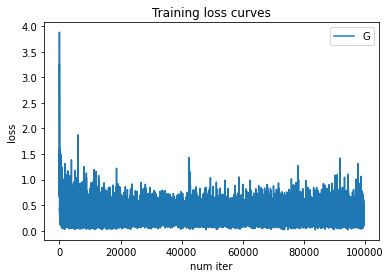

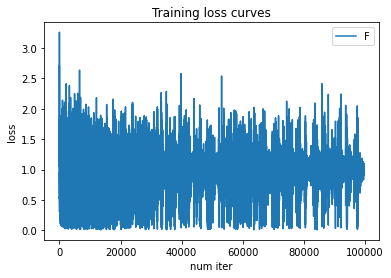

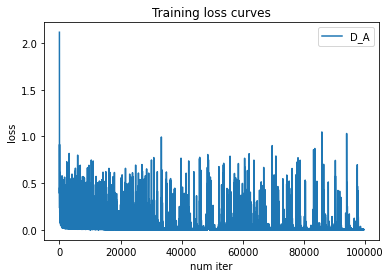

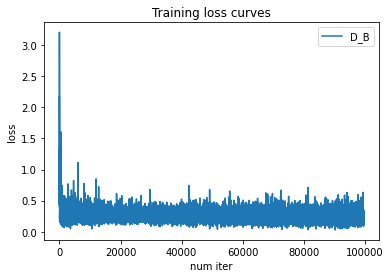

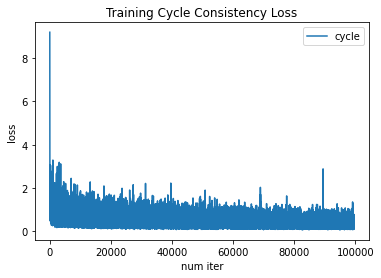

In [ ]:
import torch

checkpoint = torch.load('/content/drive/MyDrive/CIS680_2019/GANs/cycleGAN_loss.pt')

list_running_total_loss = checkpoint['list_running_total_loss']
list_running_loss_GAN_AB = checkpoint['list_running_loss_GAN_AB']
list_running_loss_GAN_BA = checkpoint['list_running_loss_GAN_BA']
list_running_loss_D_A = checkpoint['list_running_loss_D_A']
list_running_loss_D_B = checkpoint['list_running_loss_D_B']
list_running_loss_cycle = checkpoint['list_running_loss_cycle']

from matplotlib import pyplot as plt

plt.figure()
plt.title('Training loss curves')
plt.plot(list_running_loss_GAN_AB, label='G')
plt.xlabel('num iter')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure()
plt.title('Training loss curves')
plt.plot(list_running_loss_GAN_BA, label='F')
plt.xlabel('num iter')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure()
plt.title('Training loss curves')
plt.plot(list_running_loss_D_A, label='D_A')
plt.xlabel('num iter')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure()
plt.title('Training loss curves')
plt.plot(list_running_loss_D_B, label='D_B')
plt.xlabel('num iter')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.figure()
plt.title('Training Cycle Consistency Loss')
plt.plot(list_running_loss_cycle, label='cycle')
plt.xlabel('num iter')
plt.ylabel('loss')
plt.legend()
plt.show()


# CycleGAN testing

In [ ]:
from datasets import *
from models import *

from torch.utils.data import DataLoader, TensorDataset
test_batch_size = 1
test_img_dir = './edges2shoes/val/'
test_dataset = Edge2Shoe(test_img_dir)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
G_AB = torch.load('/content/drive/MyDrive/CIS680_2019/GANs/G_AB.pt')
G_BA = torch.load('/content/drive/MyDrive/CIS680_2019/GANs/G_BA.pt')

G_AB = G_AB.to(device)
G_BA = G_BA.to(device)

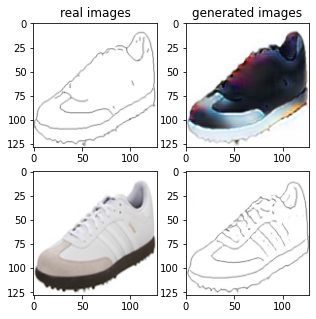

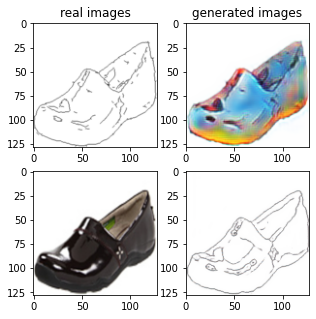

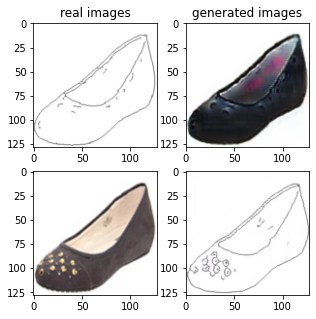

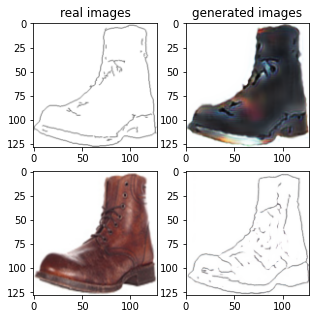

In [ ]:
from matplotlib import pyplot as plt


G_AB.eval()
G_BA.eval()

# Normalize image tensor
def norm(image):
    return (image/255.0-0.5)*2.0

# Denormalize image tensor
def denorm(tensor):
    return ((tensor+1.0)/2.0)*255.0

################################
# Please visualize real_edge, fake_shoe, real_shoe, fake_edge in 2-by-2 grids:


for i, data in enumerate(test_loader):
    edge_tensor, rgb_tensor = data
    edge_tensor, rgb_tensor = norm(edge_tensor).to(device), norm(rgb_tensor).to(device)
    real_A = edge_tensor; real_B = rgb_tensor;

    fake_B = G_AB.forward(real_A)
    fake_A = G_BA.forward(real_B)

    vis_fake_A = denorm(fake_A[0].detach()).cpu().data.numpy().astype(np.uint8)
    vis_fake_B = denorm(fake_B[0].detach()).cpu().data.numpy().astype(np.uint8)
    vis_real_B = denorm(real_B[0].detach()).cpu().data.numpy().astype(np.uint8)
    vis_real_A = denorm(real_A[0].detach()).cpu().data.numpy().astype(np.uint8)
    fig, axs = plt.subplots(2,2, figsize = (5,5))	
    
    axs[0,0].imshow(vis_real_A.transpose(1,2,0))
    axs[0,0].set_title('real images')
    axs[0,1].imshow(vis_fake_B.transpose(1,2,0))
    axs[0,1].set_title('generated images')
    axs[1,0].imshow(vis_real_B.transpose(1,2,0))
    axs[1,1].imshow(vis_fake_A.transpose(1,2,0))
    plt.show()

    if i > 2:
        break


################################        



# Quantitative Evaluation

## FID Score computation

First, we have to create 6 datasets:
- Domain A real set 1
- Domain A real set 2
- Domain A generate set

- Domain B real set 1
- Domain B real set 2
- Domain B generate set



Create folder to save images and create dataset.

In [ ]:
! mkdir real_A_1 real_A_2 gen_A
! mkdir real_B_1 real_B_2 gen_B

In [ ]:
# First create test data loader
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
test_batch_size = 1
test_img_dir = './edges2shoes/val/'
test_dataset = Edge2Shoe(test_img_dir)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

# indicate the device we will use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load learnt Generator G_AB and G_BA
G_AB = torch.load('/content/drive/MyDrive/CIS680_2019/GANs/G_AB.pt')
G_BA = torch.load('/content/drive/MyDrive/CIS680_2019/GANs/G_BA.pt')

# the size of dataset, we want to evaluate on
evaluate_num = 100

# make the gen data set and folder
real_A_set_1 = []
real_A_set_2 = []
real_B_set_1 = []
real_B_set_2 = []

gen_set_A = []
gen_set_B = []

for idx, data in enumerate(test_loader, 0):
    real_A, real_B = data
    # plt.imshow(real_A.type(torch.uint8).squeeze(0).cpu().permute(1,2,0))
    # plt.show()
    real_A, real_B = norm(real_A).to(device), norm(real_B).to(device)
    # plt.imshow(denorm(real_A).type(torch.uint8).squeeze(0).cpu().permute(1,2,0))
    # plt.imshow(denorm(real_A).squeeze(0).cpu().permute(1,2,0))
    # plt.show()
    # print(real_A.shape)
    
    if idx < evaluate_num:
        fake_A = G_BA(real_B)
        fake_B = G_AB(real_A)
        real_A_set_1.append(denorm(real_A.detach()))
        real_B_set_1.append(denorm(real_B.detach()))
        gen_set_A.append(denorm(fake_A.detach()))
        gen_set_B.append(denorm(fake_B.detach()))
        
        # plt.imshow(data[0].type(torch.uint8).squeeze(0).permute(1,2,0))
        # plt.imshow(denorm(real_A).squeeze(0).cpu().permute(1,2,0))
        # plt.imshow(denorm(real_A).type(torch.uint8).squeeze(0).cpu().permute(1,2,0))
        # plt.show()
        plt.imsave('./real_A_1/real_A' + str(idx) + '.png', denorm(real_A).type(torch.uint8).cpu().squeeze().permute(1,2,0).numpy())
        plt.imsave('./real_B_1/real_B' + str(idx) + '.png', denorm(real_B).type(torch.uint8).cpu().squeeze().permute(1,2,0).numpy())
        plt.imsave('./gen_A/gen_A' + str(idx) + '.png', denorm(fake_A).type(torch.uint8).cpu().squeeze().permute(1,2,0).numpy())
        plt.imsave('./gen_B/gen_B' + str(idx) + '.png', denorm(fake_B).type(torch.uint8).cpu().squeeze().permute(1,2,0).numpy())
        # save_image(denorm(real_A).type(torch.uint8).squeeze(), './real_A_1/real_A' + str(idx) + '.png', normalize=False)

        # save_image(denorm(real_B).detach().squeeze(), './real_B_1/real_B' + str(idx) + '.png', normalize=False)
        # save_image(denorm(fake_A).detach().squeeze(), './gen_A/gen_A' + str(idx) + '.png', normalize=False)
        # save_image(denorm(fake_B).detach().squeeze(), './gen_B/gen_B' + str(idx) + '.png', normalize=False)
        # del real_A; del real_B; del fake_A; del fake_B

    elif evaluate_num <= idx < 2*evaluate_num:
        real_A_set_2.append(real_A.detach())
        real_B_set_2.append(real_B.detach())
        plt.imsave('./real_A_2/real_A' + str(idx) + '.png', denorm(real_A).type(torch.uint8).cpu().squeeze().permute(1,2,0).numpy())
        plt.imsave('./real_B_2/real_B' + str(idx) + '.png', denorm(real_B).type(torch.uint8).cpu().squeeze().permute(1,2,0).numpy())
        # save_image(denorm(real_A).detach().squeeze(), './real_A_2/real_A' + str(idx) + '.png', normalize=False)
        # save_image(denorm(real_B).detach().squeeze(), './real_B_2/real_B' + str(idx) + '.png', normalize=False)
    
    if idx == 2*evaluate_num-1:
        break
# make 6 pytorch dataset
real_A_dataset_1 = TensorDataset(torch.cat(real_A_set_1))
real_A_dataset_2 = TensorDataset(torch.cat(real_A_set_2))
real_B_dataset_1 = TensorDataset(torch.cat(real_B_set_1))
real_B_dataset_2 = TensorDataset(torch.cat(real_B_set_2))
gen_dataset_A = TensorDataset(torch.cat(gen_set_A))
gen_dataset_B = TensorDataset(torch.cat(gen_set_B))



## Compute FID score

In [ ]:
! pip install pytorch-fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.1.1-cp36-none-any.whl size=10188 sha256=42782992208a47bbaeec8c7acc04003fd438ddaece6ca7a86b85ccb188ff2f66
  Stored in directory: /root/.cache/pip/wheels/b8/93/92/a6a8add9047b97dcb2470d2d1642450e6b76b5988e9744e3f0
Successfully built pytorch-fid


In [ ]:
print('computing FID score between real_edge_1 and real_edge_2')
! python -m pytorch_fid '/content/real_A_1' '/content/real_A_2' --gpu 0

print('computing FID score between real_edge_1 and gen_edge')
! python -m pytorch_fid '/content/real_A_1' '/content/gen_A' --gpu 0

print('computing FID score between real_shoe_1 and real_shoe_2')
! python -m pytorch_fid '/content/real_B_1' '/content/real_B_2' --gpu 0

print('computing FID score between real_shoe_1 and gen_shoe')
! python -m pytorch_fid '/content/real_B_1' '/content/gen_B' --gpu 0

computing FID score between real_edge_1 and real_edge_2
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:02<00:00, 39.6MB/s]
100% 2/2 [00:00<00:00,  6.10it/s]
100% 2/2 [00:00<00:00,  6.36it/s]
FID:  50.26312505943679
computing FID score between real_edge_1 and gen_edge
100% 2/2 [00:00<00:00,  6.28it/s]
100% 2/2 [00:00<00:00,  5.97it/s]
FID:  70.86880520062158
computing FID score between real_shoe_1 and real_shoe_2
100% 2/2 [00:00<00:00,  5.77it/s]
100% 2/2 [00:00<00:00,  5.65it/s]
FID:  59.43155002323226
computing FID score between real_shoe_1 and gen_shoe
100% 2/2 [00:00<00:00,  5.83it/s]
100% 2/2 [00:00<00:00,  5.56it/s]
FID:  129.608313215207


## Compute IS score

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('IS score for real_edge_1 data set:')
print(inception_score(real_A_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for gen_edge data set:')
print(inception_score(gen_dataset_A, cuda=True, batch_size=64, resize=True, splits=1))


print('IS score for real_shoe_1:')
print(inception_score(real_B_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for gen_shoe data set:')
print(inception_score(gen_dataset_B, cuda=True, batch_size=64, resize=True, splits=1))

IS score for real_edge_1 data set:


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



1.0017497525510533
IS score for gen_edge data set:
1.0001618207918306
IS score for real_shoe_1:
3.5049714594649286
IS score for gen_shoe data set:
2.7210041782808028
